# 02  PyTorch Neural Network Classification
Link to lesson: https://www.learnpytorch.io/02_pytorch_classification/

## Important Learnings
Some ways to improve model to solve underfitting  
1. Add more layers - each layer can potentially learn new patterns in data  
2. Add more hidden units - making the NN wider can help capture more variables in data  
3. Fitting for longer epochs  
4. Changing activation functions - non-linear activations can help NN become more flexible and less biased   
5. Changing learning rate - can help reach minima of gradient better  
6. Changing loss function  
7. Using transfer learning - ex. BERT for NLP tasks


Due to evidence that MPS backend performs worse than CPU for apply silicon, I am going to keep using CPU as device, though will write code to be device agnostic nevertheless.  
https://github.com/pytorch/pytorch/issues/77799#issuecomment-1132237526

In [3]:
import os

import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

### Data
sklearn circles - two concentric circles with some noise

In [4]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [5]:
circles = pd.DataFrame({'X1':X[:,0], 'X2':X[:,1], 'label':y})
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

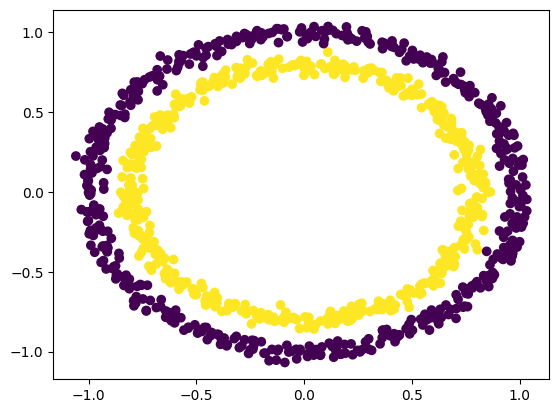

In [6]:
plt.scatter(x=circles.X1, y=circles.X2, c=y)

In [7]:
X, y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# would ideally like to save the train test data on which I build a particular model so that there's no confusion later on

### Model
1. Manually building a model where layers cascade output from one to next can be replicating by using the __nn.Sequential__ module provided by PT   
    - This builds a model with given layers in a cascading order (output of prev -> input to cur)   
    - value add is any transformation to this sequential model will apply to all layers (less repetition)  
2. The loss function does need to be fed sigmoid inputs because it has sigmoids built-in ie. it can directly work with logits only as suggested in the name `BCEWithLogitsLoss`

In [9]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


In [10]:
device = 'cpu' # MPS issues

In [11]:
class TorchClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=5)
        self.linear2 = nn.Linear(in_features=5, out_features=1)
        
    def forward(self, X):
        return self.linear2(self.linear1(X))

In [12]:
model0 = TorchClassifier()
model0.to(device)

TorchClassifier(
  (linear1): Linear(in_features=2, out_features=5, bias=True)
  (linear2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# this is the same model as above, but everything will run sequentially in this model - no control over flow
nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
untrained_preds = model0(X_test.to(device))
print(untrained_preds.shape, y_test.shape)

torch.Size([200, 1]) torch.Size([200])


In [15]:
lossfn0 = nn.BCEWithLogitsLoss()
optim0 = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [16]:
def accuracy_fn(pred, true):
    pred = torch.round(torch.sigmoid(pred))
    return 100*torch.eq(pred,true).sum().item()/len(pred)

In [17]:
# Getting labels out of model predictions (which are just floats by default)
logits = model0(X_test.to(device))
probs = torch.sigmoid(logits)
labels = torch.round(probs)

In [18]:
labels[:5].squeeze(), y_test[:5]

(tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>),
 tensor([1., 0., 1., 0., 1.]))

### Training

In [19]:
torch.manual_seed(42)

epochs = 100
train_loss, eval_loss, epoch_count = [],[],[]

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model0.train()
    y_pred = model0(X_train).squeeze()
    t_loss = lossfn0(y_pred, y_train)
    optim0.zero_grad()
    t_loss.backward()
    optim0.step()
    
    model0.eval()
    with torch.inference_mode():
        if epoch%10==0:
            epoch_count.append(epoch//10)
            train_loss.append(t_loss)

            y_test_pred = model0(X_test.to(device)).squeeze()
            e_loss = lossfn0(y_test_pred, y_test)
            eval_loss.append(e_loss)
            acc = accuracy_fn(y_test_pred,y_test)

            print(f"Epoch : {epoch} | BCE Train : {t_loss} | BCE Eval : {e_loss} | Acc : {acc}")

Epoch : 0 | BCE Train : 0.7101625800132751 | BCE Eval : 0.7013949751853943 | Acc : 56.5
Epoch : 10 | BCE Train : 0.6999455094337463 | BCE Eval : 0.69441819190979 | Acc : 58.0
Epoch : 20 | BCE Train : 0.6961800456047058 | BCE Eval : 0.6923686861991882 | Acc : 51.5
Epoch : 30 | BCE Train : 0.6946740746498108 | BCE Eval : 0.6918980479240417 | Acc : 52.0
Epoch : 40 | BCE Train : 0.694013237953186 | BCE Eval : 0.6919255256652832 | Acc : 51.0
Epoch : 50 | BCE Train : 0.6936885714530945 | BCE Eval : 0.6920937299728394 | Acc : 52.5
Epoch : 60 | BCE Train : 0.693508505821228 | BCE Eval : 0.6922867298126221 | Acc : 51.5
Epoch : 70 | BCE Train : 0.6933966279029846 | BCE Eval : 0.6924696564674377 | Acc : 53.0
Epoch : 80 | BCE Train : 0.693320631980896 | BCE Eval : 0.6926342844963074 | Acc : 53.5
Epoch : 90 | BCE Train : 0.6932655572891235 | BCE Eval : 0.6927809715270996 | Acc : 52.5


### Evaluating

In [20]:
# copying plot predictions from mrd-bourke's implementation
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    
# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})

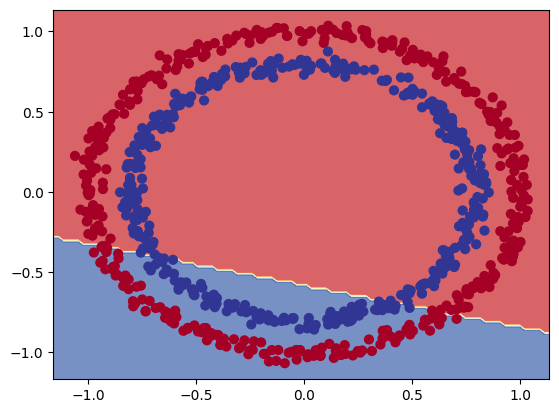

In [21]:
plot_decision_boundary(model0, X_train, y_train)

### Improving Model

In [50]:
class TorchClassifierV1(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        logits = self.relu(self.layer1(X))
        logits = self.relu(self.layer2(logits))
        return self.layer3(logits)

In [51]:
model1 = TorchClassifierV1()
model1.to(device)

TorchClassifierV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [52]:
lossfn1 = nn.BCEWithLogitsLoss()
optim1 = torch.optim.SGD(model1.parameters(), lr=0.1)

In [54]:
torch.manual_seed(42)

num_epochs = 1000
train_loss, eval_loss, epoch_count = [], [], []
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(num_epochs):
    
    # introducing batching
    
    model1.train()
    y_train_pred = model1(X_train).squeeze()
    t_loss = lossfn1(y_train_pred, y_train)
    optim1.zero_grad()
    t_loss.backward()
    optim1.step()
    
    with torch.inference_mode():
        if epoch%100==0:
            model1.eval()
            
            epoch_count.append(epoch//10)
            y_test_pred = model1(X_test).squeeze()
            e_loss = lossfn1(y_test_pred, y_test)
            acc = accuracy_fn(y_test_pred, y_test)
            
            train_loss.append(t_loss)
            eval_loss.append(e_loss)
            print(f"Epoch : {epoch} | BCE Train : {torch.round(t_loss, decimals=2)} | BCE Eval : {torch.round(e_loss, decimals=2)} | Acc : {acc}")

Epoch : 0 | BCE Train : 0.6899999976158142 | BCE Eval : 0.6899999976158142 | Acc : 52.5
Epoch : 100 | BCE Train : 0.6899999976158142 | BCE Eval : 0.6899999976158142 | Acc : 55.0
Epoch : 200 | BCE Train : 0.6899999976158142 | BCE Eval : 0.6899999976158142 | Acc : 56.0
Epoch : 300 | BCE Train : 0.6899999976158142 | BCE Eval : 0.6800000071525574 | Acc : 56.5
Epoch : 400 | BCE Train : 0.6800000071525574 | BCE Eval : 0.6800000071525574 | Acc : 56.5
Epoch : 500 | BCE Train : 0.6800000071525574 | BCE Eval : 0.6700000166893005 | Acc : 56.0
Epoch : 600 | BCE Train : 0.6700000166893005 | BCE Eval : 0.6600000262260437 | Acc : 59.0
Epoch : 700 | BCE Train : 0.6499999761581421 | BCE Eval : 0.6499999761581421 | Acc : 67.5
Epoch : 800 | BCE Train : 0.6200000047683716 | BCE Eval : 0.6200000047683716 | Acc : 79.0
Epoch : 900 | BCE Train : 0.5699999928474426 | BCE Eval : 0.5699999928474426 | Acc : 86.5


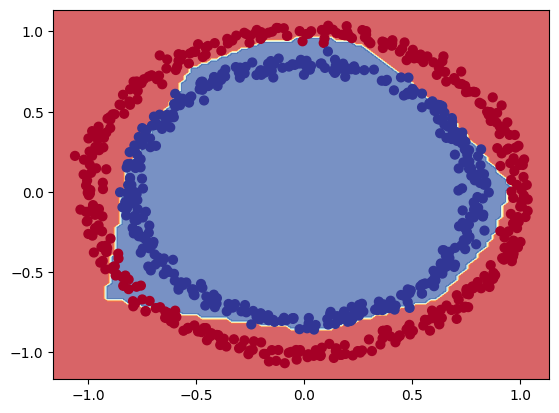

In [55]:
plot_decision_boundary(model1, X_train, y_train)

## Multi-class classification

### Data

torch.Size([800, 2]) torch.Size([200])


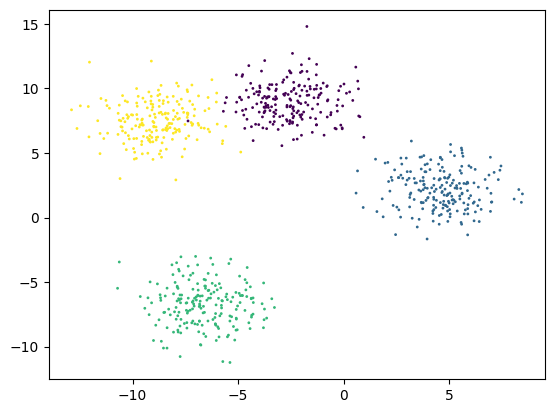

In [78]:
from sklearn.datasets import make_blobs

RANDOM_SEED = 42
NUM_CLASSES = 4
NUM_FEATURES = 2

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, 
                            cluster_std=1.5, random_state=RANDOM_SEED)

X_blob, y_blob = torch.from_numpy(X_blob).type(torch.float), torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2)
print(X_blob_train.shape, y_blob_test.shape)

plt.scatter(x=X_blob_train[:,0], y=X_blob_train[:,1], c=y_blob_train, s=1)

In [130]:
class TorchClassifierMultiV0(nn.Module):
    
    def __init__(self, in_features, out_features, hidden_units=8):
        
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=NUM_CLASSES)
        )
        
    def forward(self, X):
        return self.linear_stack(X)

In [131]:
model_multi0 = TorchClassifierMultiV0(
    in_features=X_blob_train.shape[1], 
    out_features=NUM_CLASSES,
    hidden_units=10
)
model_multi0

TorchClassifierMultiV0(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)

In [132]:
lossfn_multi0 = nn.CrossEntropyLoss()
optim_multi0 = torch.optim.SGD(model_multi0.parameters(), lr=0.1)

In [133]:
model_multi0(X_blob_train).shape

torch.Size([800, 4])

In [134]:
def accuracy_fn(y_gt, y_pred):
    return 100*torch.eq(y_gt, y_pred).sum()/len(y_gt)

In [135]:
def model_multi0_train(
    model = model_multi0, lsfn = lossfn_multi0, opt = optim_multi0,
    Xt = X_blob_train, yt = y_blob_train
):
    
    model.train()
    yt_logits = model(Xt)
    yt_pred = torch.argmax(torch.softmax(yt_logits, dim=1), dim=1)

    t_loss = lsfn(yt_logits, yt)
    opt.zero_grad()
    t_loss.backward()
    opt.step()
    
    return t_loss
    
def model_multi0_eval(
    model = model_multi0, lsfn = lossfn_multi0,
    Xe = X_blob_test, ye = y_blob_test,
):
    with torch.inference_mode():
        model.eval()
        ye_logits = model(Xe)
        ye_pred = torch.argmax(torch.softmax(ye_logits, dim=1), dim=1)
        e_loss = lsfn(ye_logits, ye)
        acc = accuracy_fn(ye_pred, ye)
        return e_loss, acc

In [136]:
torch.manual_seed(RANDOM_SEED)

epochs = 100
train_loss_multi, eval_loss_multi = [], []
for epoch in range(epochs):
    
    t_loss = model_multi0_train()
    if epoch%10==0:
        e_loss, acc = model_multi0_eval()
        train_loss_multi.append(t_loss)
        eval_loss_multi.append(e_loss)
        
        print(f"Epoch {epoch} | CE Train : {t_loss} | CE Test : {e_loss} | Acc : {acc}")

Epoch 0 | CE Train : 1.5057979822158813 | CE Test : 1.4154810905456543 | Acc : 1.5
Epoch 10 | CE Train : 1.0591919422149658 | CE Test : 1.0163085460662842 | Acc : 69.5
Epoch 20 | CE Train : 0.5367418527603149 | CE Test : 0.4925563931465149 | Acc : 92.5
Epoch 30 | CE Train : 0.354699969291687 | CE Test : 0.3233731985092163 | Acc : 99.5
Epoch 40 | CE Train : 0.19873550534248352 | CE Test : 0.168045312166214 | Acc : 99.5
Epoch 50 | CE Train : 0.09918150305747986 | CE Test : 0.07969721406698227 | Acc : 99.5
Epoch 60 | CE Train : 0.06534875929355621 | CE Test : 0.05122155696153641 | Acc : 99.5
Epoch 70 | CE Train : 0.051735278218984604 | CE Test : 0.03985189273953438 | Acc : 99.5
Epoch 80 | CE Train : 0.04468685761094093 | CE Test : 0.03398499637842178 | Acc : 99.5
Epoch 90 | CE Train : 0.04043439030647278 | CE Test : 0.030442656949162483 | Acc : 99.5


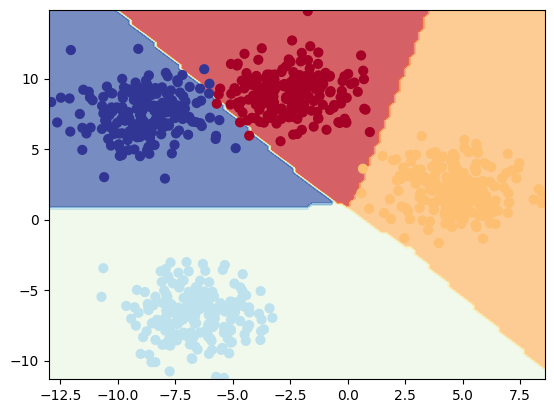

In [137]:
plot_decision_boundary(model_multi0, X_blob_train, y_blob_train)